Установка зависимостей

In [456]:
!pip install -q -U kaggle_environments

Импорт библиотек

In [457]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

# **Определяем агентов.** С помощью классов, чтобы избежать использования глобальных переменных для хранения состояния

1. Всегда камень

In [458]:
class RockAgent:
    def __call__(self, observation, configuration):
        # 0 - камень
        return 0


2. Всегда бумага

In [459]:
class PaperAgent:
    def __call__(self, observation, configuration):
        # 1 - бумага
        return 1

3. Всегда ножницы

In [460]:
class ScissorsAgent:
    def __call__(self, observation, configuration):
        # 2 - ножницы
        return 2

4. Повторение за противником

In [461]:
class CopyAgent:
    def __call__(self, observation, configuration):
        # если не первый ход
        if observation.step > 0:
            # копируем ход противника
            return observation.lastOpponentAction
        else:
            # случайный ход
            return random.randrange(0, configuration.signs)

5. Рандом

In [462]:
class RandomAgent:
    def __call__(self, observation, configuration):
        # случайный ход
        return random.randrange(0, configuration.signs)

6. Ход, с которым был бы проигрыш в предыдущем раунде

In [463]:
class ReactionLossAgent:
    def __call__(self, observation, configuration):
        # если не первый ход
        if observation.step > 0:
            # проигрышный ход для предыдущего раунда
            return (observation.lastOpponentAction + 2) % configuration.signs
        else:
            # случайный ход
            return random.randrange(0, configuration.signs)

7. Ход, с которым был бы выигрыш в предыдущем раунде

In [464]:
class ReactionWinAgent:
    def __call__(self, observation, configuration):
        # если не первый ход
        if observation.step > 0:
            # выигрышный ход для предыдущего раунда
            return (observation.lastOpponentAction + 1) % configuration.signs
        else:
            # случайный ход
            return random.randrange(0, configuration.signs)

8. Ход, с которым выиграл бы против своего хода в прошлом раунде

In [465]:
class MyReactionWinAgent:
    def __init__(self):
        # храним свой последний ход
        self.action = -1

    def __call__(self, observation, configuration):
        # если не было своих ходов
        if self.action < 0:
            # случайный ход
            self.action = random.randrange(0, configuration.signs)
            return self.action
        else:
            # выигрышный ход против себя в предыдущем враунде
            self.action = (self.action + 1) % configuration.signs
            return self.action


9. Ход, с которым проиграл бы против своего хода в прошлом раунде

In [466]:
class MyReactionLossAgent:
    def __init__(self):
        # храним свой последний ход
        self.action = -1

    def __call__(self, observation, configuration):
        # если не было своих ходов
        if self.action < 0:
            # случайный ход
            self.action = random.randrange(0, configuration.signs)
            return self.action
        else:
            # проигрышный ход против себя в предыдущем враунде
            self.action = (self.action + 2) % configuration.signs
            return self.action

10. Статистичекий. Реагирует на самый частый ход

In [467]:
class StatisticalMaxAgent:
    def __init__(self):
        # храним ходы, сделанные противником, и их количество
        self.histogram = {}

    def __call__(self, observation, configuration):
        # Если не первый ход
        if observation.step > 0:
            # добавляем единичку к определенному ходу
            if observation.lastOpponentAction in self.histogram.keys():
                self.histogram[observation.lastOpponentAction] += 1
            else:
                self.histogram[observation.lastOpponentAction] = 1
            # получаем самый часто используемый противником ход
            res, count = sorted(self.histogram.items(), key=lambda x: x[1], reverse=True)[0]
            # ходим против этого хода
            return (res + 1) % configuration.signs
        else:
            # случайный ход
            return random.randrange(0, configuration.signs)



11. Статистический. Реагирует на самый неиспользуемый ход. Пока противник не использует все варианты ходов - реагирует на неиспользуемые варианты противника.

In [468]:
class StatisticalMinAgent:
    def __init__(self):
        # храним ходы, сделанные противником, и их количество
        self.histogram = {}

    def __call__(self, observation, configuration):
        # Если не первый ход
        if observation.step > 0:
            # добавляем единичку к определенному ходу
            if observation.lastOpponentAction in self.histogram.keys():
                self.histogram[observation.lastOpponentAction] += 1
            else:
                self.histogram[observation.lastOpponentAction] = 1
        else:
            # случайный ход
            return random.randrange(0, configuration.signs)

        # ход, против которого будем ходить
        res = 0
        # если противник еще не применял какого-нибудь хода
        if len(self.histogram) < 3:
            for i in range(3):
                # находим не использовавшийся ход
                if i not in self.histogram.keys():
                    res = i
                    break
        else:
            # получаем наименее используемый ход
            res, count = sorted(self.histogram.items(), key=lambda x: x[1], reverse=False)[0]
        # ходим против этого хода
        return (res + 1) % configuration.signs

12. Статистический. Реагирует на средне используемый ход. Пока противник не использует все варианты ходов - реагирует на неиспользуемые варианты противника.

In [469]:
class StatisticalMidAgent:
    def __init__(self):
        # храним ходы, сделанные противником, и их количество
        self.histogram = {}

    def __call__(self, observation, configuration):
        # Если не первый ход
        if observation.step > 0:
            # добавляем единичку к определенному ходу
            if observation.lastOpponentAction in self.histogram.keys():
                self.histogram[observation.lastOpponentAction] += 1
            else:
                self.histogram[observation.lastOpponentAction] = 1
        else:
            # случайный ход
            return random.randrange(0, configuration.signs)

        # ход, против которого будем ходить
        res = 0
        # если противник еще не применял какого-нибудь хода
        if len(self.histogram) < 3:
            for i in range(3):
                # находим не использовавшийся ход
                if i not in self.histogram.keys():
                    res = i
                    break
        else:
            # получаем средне используемый ход
            res, count = sorted(self.histogram.items(), key=lambda x: x[1], reverse=False)[1]
        # ходим против этого хода
        return (res + 1) % configuration.signs

13. Цикличный, повторяя по 2. Например 2-2-0-0-1-1-2-2-...

In [470]:
class Cycle2Agent:
    def __init__(self):
        # храним свой последний ход
        self.action = -1
        # повторяем ли мы последний ход
        self.repeat = True

    def __call__(self, observation, configuration):
        # если не было своих ходов
        if self.action < 0:
            # случайный ход
            self.action = random.randrange(0, configuration.signs)
            return self.action

        # +0 при повторении, иначе +1
        self.action = (self.action + int(not self.repeat) % 2) % configuration.signs
        self.repeat = not self.repeat
        # ходим
        return self.action

# Воспользуемся функцией evaluate из библиотеки kaggle_environments с помощью которой запустим наших агентов и проведем эксперимент на заданном количестве игр

In [471]:
# используемые агенты
agents = {
    'rock': RockAgent(),
    'paper': PaperAgent(),
    'scissors': ScissorsAgent(),
    'copy': CopyAgent(),
    'random': RandomAgent(),
    'reaction_loss': ReactionLossAgent(),
    'reaction_win': ReactionWinAgent(),
    'my_reaction_win': MyReactionWinAgent(),
    'my_reaction_loss': MyReactionLossAgent(),
    'statistical_max': StatisticalMaxAgent(),
    'statistical_min': StatisticalMinAgent(),
    'statistical_mid': StatisticalMidAgent(),
    'cycle2': Cycle2Agent(),
}

# словарь, где ключ - агент, значение - количество побед
agents_wins = {}
for key in agents.keys():
    agents_wins[key] = 0

# турнир. Вложенный цикл - каждый с каждым
for i in range(len(agents)):
    for j in range(i + 1, len(agents)):
        # ключи агентов по индексу
        agent1_key = list(agents.keys())[i]
        agent2_key = list(agents.keys())[j]
        # проводим раунд
        res = evaluate(
            "rps", # среда - КНБ
            [agents[agent1_key], agents[agent2_key]], # агенты
            configuration={"episodeSteps": 100} # количество эпизодов
        )

        # если у левого больше побед => +2 очка
        if res[0][0] > res[0][1]:
            agents_wins[agent1_key] += 2
        # если у правого больше побед => +2 очка
        elif res[0][0] < res[0][1]:
            agents_wins[agent2_key] += 2
        # если ничья => +1 очко каждому
        else:
            agents_wins[agent1_key] += 1
            agents_wins[agent2_key] += 1

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:1281: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


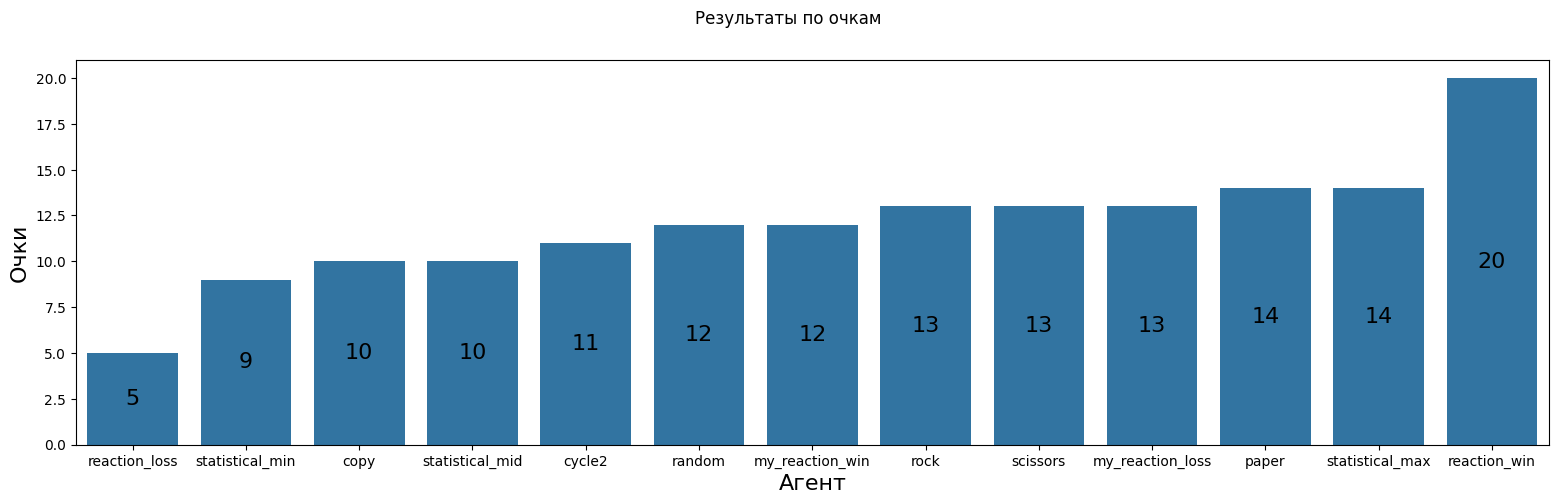

In [472]:
# Сортируем по возрастанию побед
res_wins = dict(sorted(agents_wins.items(), key=lambda x: x[1]))

# Названия агентов и их очки
names = [key for key in res_wins.keys()]
points = [x[1] for x in res_wins.items()]

# создаем и отображаем график
dfp = pd.DataFrame({'agent': names, 'point': points})
plt.figure(figsize=(19, 5))
splot = sns.barplot(x='agent', y='point', data=dfp)
plt.xlabel('Агент', size=16)
plt.ylabel('Очки', size=16)
plt.bar_label(splot.containers[0], size=16, label_type='center')
plt.suptitle('Результаты по очкам')
plt.show()

# **В результате, лучше всех себя показала стратегия использовать выигрышный ход для прошлого раунда**